# Jeux de données pour la classification des graphes : capitales et campagnes

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely

## Prélèvement automatique de zones géographiques

L'extraction manuelle des zones à l'aide de QGIS est trop fastidieuse, il faut un moyen d'automatiser le processus. En plus, cette méthode n'est pas précise. Geopandas donne la possibilité de charger uniquement une partie du jeu de données complet en fonction de coordonnées données. C'est ce que nous allons utiliser.

Le module GeoPy, intégré au sein de Geopandas, permet de convertir un nom en coordonnées géographiques. À partir de ce point, nous pouvons créer une zone avec un certain rayon et extraire la partie du jeu de données complet qui lui correspond.

Des sites comme http://www.geonames.org/ permettent aussi de récupérer des coordonnées géographiques à partir d'un nom


In [3]:
paris_location = gpd.tools.geocode("Paris")
paris_location

,geometry,address
0,POINT (2.32004 48.85889),"Paris, 75000;75001;75002;75003;75004;75005;750..."


In [4]:
paris_area = paris_location.geometry.buffer(10)

/tmp/ipykernel_94662/1448691870.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  paris_area = paris_location.geometry.buffer(10)


In [5]:
paris_location.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
zone_11_gdf = gpd.read_file("../data/zones/zones.gpkg", layer="zone-11")
zone_11_gdf.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [11]:
paris_location_projected = paris_location.to_crs(epsg=3035)

In [12]:
paris_area = paris_location_projected.geometry.buffer(25000)
paris_area

0    POLYGON ((3783451.870 2889983.454, 3783331.488...
dtype: geometry

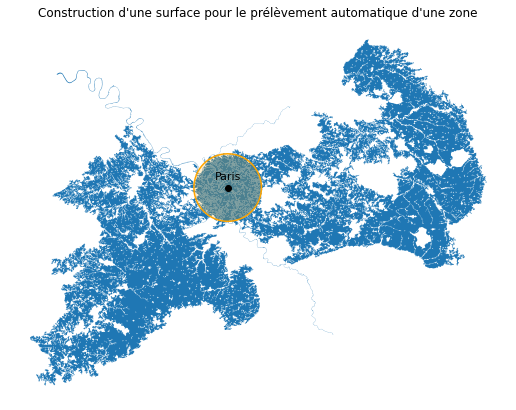

In [13]:
f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf.plot(ax=ax)
paris_area.exterior.plot(ax=ax, color="orange")
paris_area.plot(ax=ax, color="orange", alpha=0.2)
center = paris_area.geometry.centroid
center.plot(ax=ax, color="black")
plt.annotate("Paris", xy=(center.x, center.y), xytext=(center.x, center.y + 6000), color="black", fontsize=11,
             horizontalalignment="center")
plt.title("Construction d'une surface pour le prélèvement automatique d'une zone")
ax.set_axis_off()
plt.show()

On a réussi à créer une zone à partir d'un nom de ville, on peut maintenant extraire les données correspondantes à partir du jeu de données complet

In [15]:
paris_gdf = gpd.read_file("../data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg",
                          mask=paris_area)

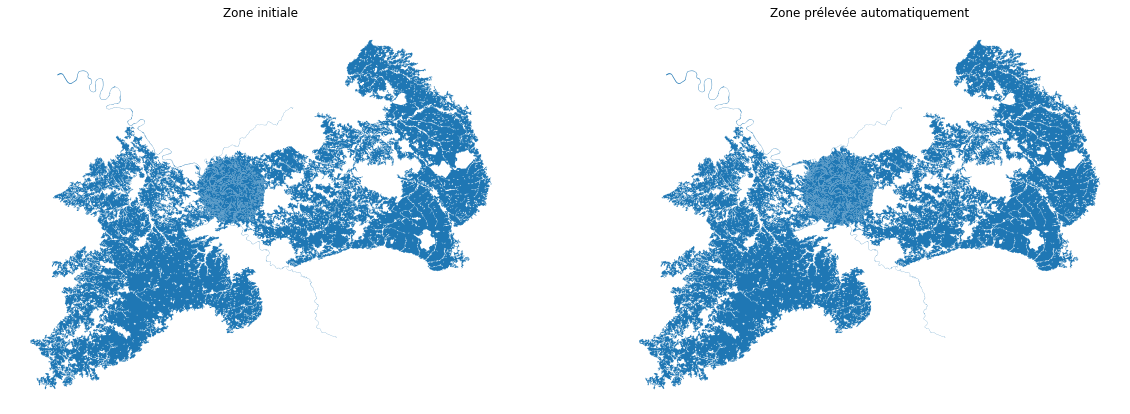

In [16]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
zone_11_gdf.plot(ax=ax)
ax.set_axis_off()
plt.title("Zone initiale")
ax = plt.subplot(122)
paris_gdf.plot(ax=ax)
plt.title("Zone prélevée automatiquement")
ax.set_axis_off()
plt.show()

On retrouve bien la même région de la carte que celle extraite manuellement.

In [19]:
def extract_zone(location, area_size, coords=False, data_preprocessing=None,
                 data_path="../data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"):
    area = None
    area_radius = np.sqrt(area_size * 1e6 / np.pi)

    if coords is True:
        assert isinstance(location, tuple)
        area = shapely.geometry.Point(location[0], location[1]).buffer(area_radius)

    else:
        location_coords = gpd.tools.geocode(location).to_crs(epsg=3035)
        area = location_coords.geometry.buffer(area_radius)

    gdf = gpd.read_file(data_path, mask=area)
    if data_preprocessing is not None:
        gdf = data_preprocessing(gdf)

    return gdf

## Vérification des longueurs

Vérifions les longueurs calculées par geopandas sur une zone dont on connait les dimensions. Par exemple, le lac d'Annecy:

* Périmètre : 38 km
* Aire :  26.5 km²

In [20]:
gdf = extract_zone("Lac d'Annecy", 1)

In [22]:
legend = pd.read_csv("../data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/Legend/clc_legend.csv")

In [24]:
legend

,GRID_CODE,CLC_CODE,LABEL1,LABEL2,LABEL3,RGB
0,1,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077
1,2,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric,255-000-000
2,3,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units,204-077-242
3,4,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,204-000-000
4,5,123,Artificial surfaces,"Industrial, commercial and transport units",Port areas,230-204-204
5,6,124,Artificial surfaces,"Industrial, commercial and transport units",Airports,230-204-230
6,7,131,Artificial surfaces,"Mine, dump and construction sites",Mineral extraction sites,166-000-204
7,8,132,Artificial surfaces,"Mine, dump and construction sites",Dump sites,166-077-000
8,9,133,Artificial surfaces,"Mine, dump and construction sites",Construction sites,255-077-255
9,10,141,Artificial surfaces,"Artificial, non-agricultural vegetated areas",Green urban areas,255-166-255


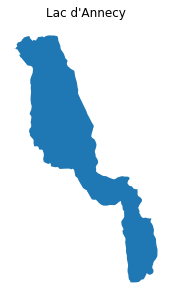

In [26]:
f, ax = plt.subplots(figsize=(10, 5))
gdf["land_type"] = legend[legend["CLC_CODE"] == int(gdf["Code_18"])]["LABEL1"].iloc[0]
gdf.plot(ax=ax)
ax.set_axis_off()
plt.title("Lac d'Annecy")
plt.show()

In [27]:
print(f"Aire calculée: {round(gdf.iloc[0].geometry.area / 1e6, 1)} km²")
print(f"Périmètre calculé: {round(gdf.iloc[0].geometry.length / 1e3, 1)} km")

Aire calculée: 26.7 km²
Périmètre calculé: 37.0 km


In [28]:
print(f"Aire - écart : {round((abs(26.5 - gdf.iloc[0].geometry.area / 1e6) / 26.5) * 100, 2)} %")
print(f"Périmètre - écart : {round((abs(38 - gdf.iloc[0].geometry.length / 1e3) / 38) * 100, 2)} %")

Aire - écart : 0.61 %
Périmètre - écart : 2.62 %


Les longueurs calculées correspondent aux longueurs attendues. On pourra donc s'en servir pour l'apprentissage.

## Dataset : capitales et campagnes

J'ai recensé des grandes capitales d'Europe de taille similaire.

In [29]:
countries = ["Allemagne", "Espagne", "Finlande", "France", "Italie", "Pologne", "Roumanie", "Royaume-Uni", "Suède"]
capitals = ["Berlin", "Madrid", "Helsinki", "Paris", "Rome", "Varsovie", "Bucarest", "Londres", "Stockholm"]

J'ai également récupéré manuellement des coordonnées se trouvant dans des vastes zones rurales à travers l'Europe.

In [33]:
campaigns_coords = pd.read_csv("../data/capitales/campaigns_coords.csv")
campaigns_coords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       36 non-null     float64
 1   Y       36 non-null     float64
dtypes: float64(2)
memory usage: 704.0 bytes


### Extraction des zones de la BD Corine Land Cover

L'objectif est de récupérer des zones qui représentent au mieux le type de terrain qu'on souhaite extraire (urbain pour les capitales et rural pour les campagnes). Ainsi, on ne souhaite pas inclure des parcelles représentant des zones rurales pour les capitales et des zones urbaines pour les campagnes. Il faut donc choisir une taille de zone assez grande pour avoir un nombre d'instances suffisant pour l'apprentissage, mais pas trop grande pour ne pas récupérer la périphérie de ce que l'on veut extraire.

In [34]:
land_types = legend["LABEL1"].unique().tolist()

In [35]:
def test_extraction_sizes(locations, area_sizes, plot=True, coords=False, data_preprocessing=None,
                          locations_labels=None):
    nb_locations = len(locations)
    nb_sizes = len(area_sizes)

    category_counts_dict = {category: np.zeros(nb_locations) for category in
                            ["nb_areas", "total_size", "avg_area_size"] + land_types}
    avg_counts_dict = {category: np.zeros(nb_sizes) for category in
                       ["total_nb_areas", "avg_nb_areas", "avg_total_size", "avg_area_size"] + land_types}

    if plot is True:
        plt.figure(figsize=(20, 15))

    for j in range(nb_sizes):
        print(f"size={area_sizes[j]}", end=" ")

        for i in range(nb_locations):
            gdf = extract_zone(locations[i], area_size=area_sizes[j], coords=coords,
                               data_preprocessing=data_preprocessing)

            nb_instances = len(gdf)
            counts = gdf["land_type"].value_counts()

            for category, count in counts.iteritems():
                category_counts_dict[category][i] = round(count / nb_instances, 2)

            category_counts_dict["nb_areas"][i] = nb_instances
            category_counts_dict["total_size"][i] = round(gdf.dissolve().area / 1e6, 2)
            category_counts_dict["avg_area_size"][i] = round(gdf.area.median() / 1e6, 2)

        category_counts_df = pd.DataFrame(category_counts_dict, index=locations_labels)
        category_counts_df["nb_areas"] = category_counts_df["nb_areas"].astype(int)

        if plot is True:
            if j > 0 and j % 6 == 0:
                plt.show()
                plt.figure(figsize=(20, 15))

            ax = plt.subplot(3, 2, (j % 6) + 1)
            category_counts_df.iloc[:, 3:].plot.barh(ax=ax, stacked=True)
            plt.legend(loc='lower left')
            plt.title(f"A = {area_sizes[j]} km²")

        avg_counts_dict["total_nb_areas"][j] = category_counts_df["nb_areas"].sum()
        avg_counts_dict["avg_nb_areas"][j] = int(category_counts_df["nb_areas"].mean())
        avg_counts_dict["avg_total_size"][j] = round(category_counts_df["total_size"].mean(), 2)
        avg_counts_dict["avg_area_size"][j] = round(category_counts_df["avg_area_size"].mean(), 2)

        for category in category_counts_df.iloc[:, 3:]:
            avg_counts_dict[category][j] = round(category_counts_df[category].mean(), 2)

        print("[ok]", end=" | ")

    if plot is True:
        plt.show()

    avg_counts_df = pd.DataFrame(avg_counts_dict, index=area_sizes)
    avg_counts_df["total_nb_areas"] = avg_counts_df["total_nb_areas"].astype(int)
    avg_counts_df["avg_nb_areas"] = avg_counts_df["avg_nb_areas"].astype(int)

    return avg_counts_df

#### Capitales

In [36]:
capitals_location = [f"{capitals[i]}, {countries[i]}" for i in range(len(capitals))]
capitals_location

['Berlin, Allemagne',
 'Madrid, Espagne',
 'Helsinki, Finlande',
 'Paris, France',
 'Rome, Italie',
 'Varsovie, Pologne',
 'Bucarest, Roumanie',
 'Londres, Royaume-Uni',
 'Stockholm, Suède']

In [ ]:
def data_preprocessing(gdf, legend_path="../data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/Legend/clc_legend.csv"):
    legend = pd.read_csv(legend_path)
    gdf["land_type"] = gdf["Code_18"].map(lambda x: legend[legend["CLC_CODE"] == int(x)]["LABEL1"].iloc[0])
    return gdf


avg_counts_df = test_extraction_sizes(capitals_location, area_sizes=range(10, 70, 10),
                                      data_preprocessing=data_preprocessing,
                                      locations_labels=capitals, plot=True)
avg_counts_df

Nous pourrons prendre une taille d'extraction entre 20 et 30 km² pour maximiser le taux de parcelles urbaines dans le jeu de données tout en conservant un nombre important d'instances. Il sera peut-être nécessaire, en fonction des résultats de l'apprentissage, d'augmenter ce rayon ou d'utiliser plus de villes pour avoir plus d'instances.

#### Campagnes

In [39]:
campaigns_location = list(zip(campaigns_coords.X, campaigns_coords.Y))
campaigns_location[:5]

[(3686415.2653172, 2439933.60826211),
 (3120844.25657434, 3435517.01351049),
 (4502377.90348854, 4197347.30709593),
 (5167704.17311086, 4498925.45729197),
 (5055232.75318183, 2557364.53118775)]

In [ ]:
avg_counts_df = test_extraction_sizes(campaigns_location, area_sizes=range(10, 70, 10),
                                      data_preprocessing=data_preprocessing,
                                      coords=True, plot=False)
avg_counts_df

La répartition des catégories de parcelle en fonction du rayon d'extraction des zones est plutôt uniforme. Cela s'explique car les campagnes sont en général plus vastes et uniformes que les villes. Elles semblent donc poser moins de problème.

On considèrera donc uniquement la contrainte imposée par les villes et on prendra une taille d'extraction de 20 km².

### Enregistrement des données

In [ ]:
def cap_camp_preprocessing(gdf):
    # gdf = gdf[~gdf["Code_18"].isin(["122", "511", "523"])]  # suppression des routes, cours d'eau, mer et océan
    gdf["Node_ID"] = range(len(gdf))  # pour simplifier la création des graphes
    # todo : gérer les codes 18
    # todo : gérer les nodata
    return gdf


area_size = 20

# capitales
for i in range(len(capitals)):
    gdf = extract_zone(capitals_location[i], area_size=area_size, coords=False,
                       data_preprocessing=cap_camp_preprocessing)
    gdf.to_file("../data/capitales/capitales.gpkg", driver="GPKG", layer=capitals[i])

# campagnes
for i in range(len(campaigns_coords)):
    gdf = extract_zone(campaigns_location[i], area_size=area_size, coords=True,
                       data_preprocessing=cap_camp_preprocessing)
    gdf.to_file("../data/capitales/capitales.gpkg", driver="GPKG", layer=f"Camp-{i}")